## Risk and Efficiency of Fixed vs. Dynamic Collateral-to-Debt Ratios in DeFi

Most lending/borrowing protocols use fixed colateral-to-debt ratios. We believe that fixed CDRs are not only detrimental to capital efficiency but could introduce tail risks when markets are in turmoil. We propose a protocol in which risk is controlled via a dynamically-set CDR. We show that such a protocol not only raises capital efficiency, but also functions well with sudden market movements. 

## Dynamic CDR  

We set the dynamic CDR ratio using to 3 inputs: volatility, liquidity, and total CDR of the protocol. These inputs are updated daily. 

1. Volatility: We define $\pi$ as the residual risk that the protocol accepts for ending up with bad debt. Assuming Geometric Brownian Motion, we can show that for a debt with amount D, Collateral $c(t)$ could be determined using: 
$c(t) \geq De^{\sigma\sqrt{\Delta T} N^{-1}(\pi)}$.  
Where $\Delta T$ is the time distance between borrowing and next input update, and $\sigma$ is the underlying asset volatility. We can write the liquidation threshold as:  

$$ l(t) = (1 + e^{\sigma\sqrt{\Delta T} N^{-1}(\pi)}) \approx 1 + \sigma\sqrt{\Delta T} N^{-1}(\pi) $$

2. Liquidity: If a collateral value falls below the equation above, the protocol allows the liquidation of the loan. In instances where the loan is too big or there is not enough liquidity available on the market, cost of liquidation quadratically increases. Therefore, a liquidator should be compensated for the cost of their operation, otherwise the bad debt just sits on the protocol's book. We estimate this cost using liquidity available on Uniswap and tradFi methodology on efficient liquidations. 
$$ x(t) = E[\text{liquidation Cost}] \propto  \sigma \text { and } \text{Uniswap Liquidity} $$


3. Total CDR: Even though the protocol may accept the residual risk $\pi$ of any one loan becoming insolvent (which  leads to borrowers becoming liquidated), it only accepts truly negilible risk of becoming insolvent as a whole (i.e. can't pay back lenders). This is possible by adjusting the dynamic CDR ratio according to total CDR. If the total collateral of the protocol, $C(t)$ falls below $C_{min} = De^{\sigma\sqrt{\Delta T} N^{-1}(\pi_{total})}$, where $\pi_{total}$ could be set to a neglibile probability (e.g. 0.000001 or 6 standard deviations out), loans start to get liquidated in the order of their CDR, to bring the protocol back to $C_{min}$.


In [13]:
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
import matplotlib.dates as md 
from scipy.stats import norm
import copy

In [14]:
import utils 
from dynamicLB import dynamicLBProtocol as protocol
from dynamicLiquidator import dynamicLiquidator as liquidator

Initializing the protocol and querying current CDR.

In [15]:
start_price = 1282 
start_volatility = 0.82 / np.sqrt(365)
pi = 0.95
pi_total = 0.999999
empiric_protocol = protocol(start_volatility, start_price, pi, pi_total) 

empiric_protocol.calculate_liquidation_threshold(10000)

1.0706071344257515

Processing loans of different sizes and collateral. 

In [16]:
start_price = 1282 
start_volatility = 0.82 / np.sqrt(365)
empiric_protocol = protocol(start_volatility, start_price, pi, pi_total)

debts = [[100, 105, 1], [200, 218, 2],[10000, 15800, 3], [1e6, 1.07e6, 4], [1e7, 1.3e7, 5]]

for debt in debts: 
    empiric_protocol.process_order(debt[0], debt[1], debt[2])

empiric_protocol.status()


1.0705984581149686
Loan request rejected. CDR too low.
1.0705985457544716
Loan order placed.
1.2040293557417363
Loan order placed.
1.0714747655040278
Loan request rejected. CDR too low.
1.0793623207610847
Loan order placed.
Protocol's Status Summary
-----------------------------------
Cummulative Debt: 10010200.0
Cummulative Collateral: 13016018.0
Total CDR: 130.027551897065
Minimum Total Collateral: 120.40205917914506
The protocol is not in Recovery Mode.
Protocol's balance sheet:
[[2.00e+02 2.18e+02]
 [1.00e+07 1.30e+07]
 [1.00e+04 1.58e+04]]


## Capital Efficiency 

Liquity is among the most efficient protocols in DeFi. We compare our Dynamic CDR protocol to Liquity's in terms of capital efficiency. We show that our protocol is not only more efficient in terms CDR requirements, but is also more borrower-friendly in the events of liquidation. 

In [17]:
market_df = pd.read_csv("data/market_data.csv", index_col = 0) 
market_df.head()

,ETH,USDC,ETH/USDC,RVOL,DVOL
1635033600,4171.856106,1.001181,4166.935302,61.846703,86.31
1635120000,4084.425666,1.000258,4083.372709,64.411878,89.88
1635206400,4217.337926,0.999618,4218.947791,62.717645,84.45
1635292800,4132.173350,1.000109,4131.721756,64.035612,89.01
1635379200,3924.815524,1.000218,3923.959024,65.483987,88.46


In [18]:
l_df = pd.read_csv("data/LiquityTCR.csv", index_col = "timestamps")
l_df = l_df[l_df.index > 1635033600]
l_df.index = l_df.index.astype('int')
l_df.head()

,CCR,TCR
timestamps,,
1635048000,1.5,2.832702
1635048000,1.5,2.817936
1635048000,1.5,2.813870
1635048000,1.5,2.812696
1635048000,1.5,2.798454


In [19]:
empiric_protocol = protocol(start_volatility, start_price, pi, pi_total)

dynamicLiqThreshold = np.zeros((2,len(market_df)))
rmodeThreshold = np.zeros(len(market_df))

for i in range(len(market_df)): 
    empiric_protocol.update_vars(market_df["DVOL"].values[i]/(np.sqrt(365) * 100), market_df["ETH/USDC"].values[i]) 
    dynamicLiqThreshold[0][i] = empiric_protocol.calculate_liquidation_threshold(100)
    dynamicLiqThreshold[1][i] = empiric_protocol.calculate_liquidation_threshold(1e7)
    rmodeThreshold[i] = empiric_protocol.get_recovery_Threshold()

<bound method Figure.show of <Figure size 1500x900 with 1 Axes>>

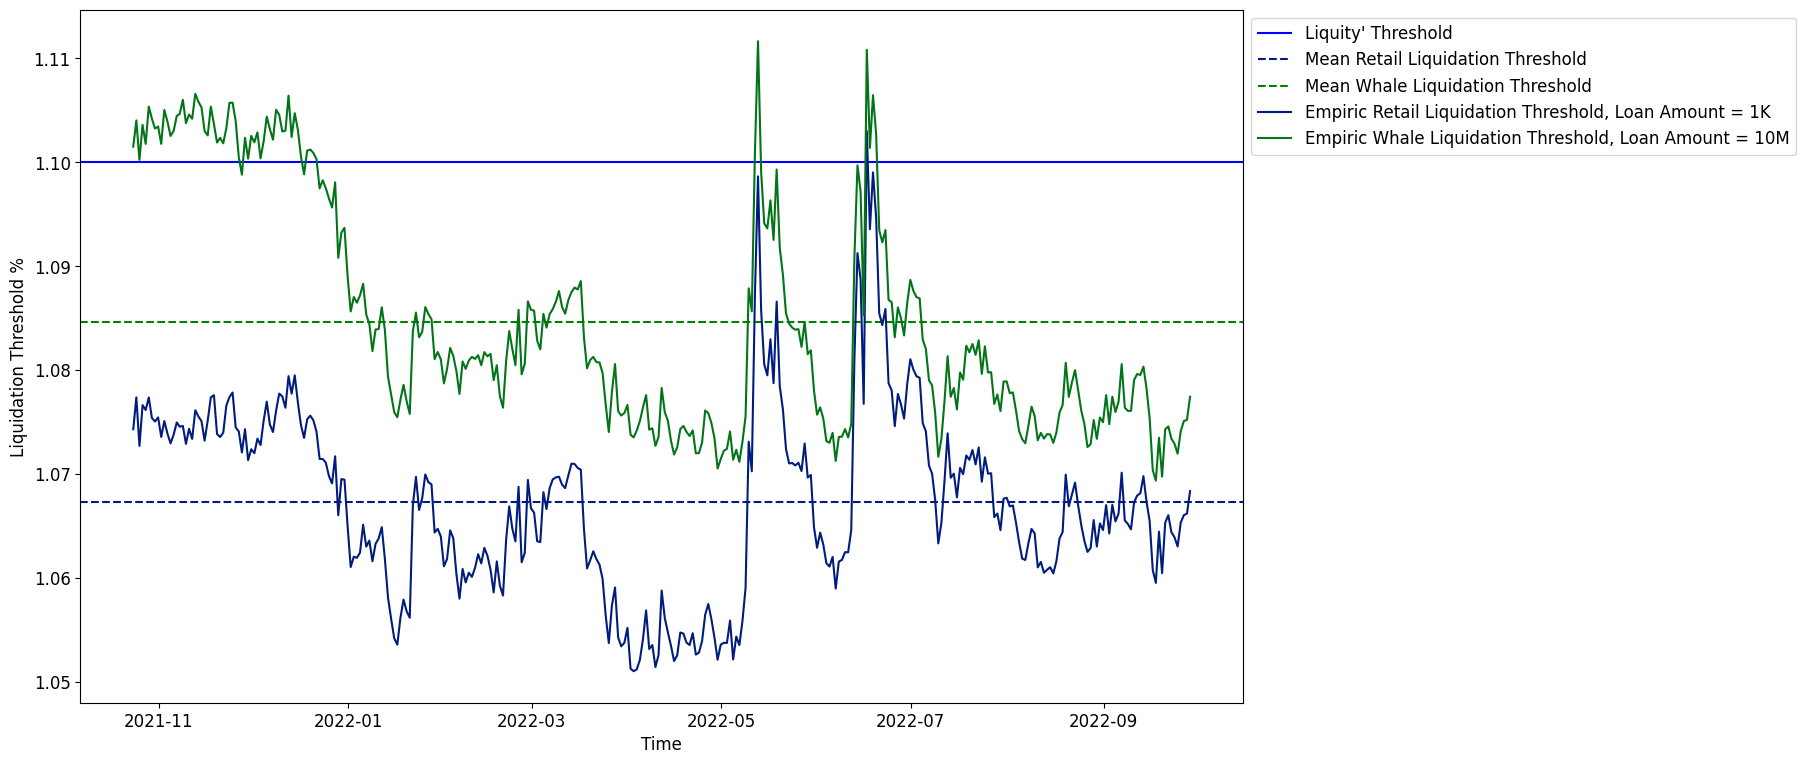

In [20]:
plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams["font.size"] = 12
plt.rcParams["font.weight"] = "normal"
plt.style.use(plt.style.available[15])
fig = plt.figure()

dates=[datetime.fromtimestamp(ts) for ts in market_df.index]

xfmt = md.DateFormatter('%Y-%m') 
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)


plt.axhline( 1.1, label = "Liquity' Threshold", color = "blue")
plt.axhline( np.mean(dynamicLiqThreshold[0]), linestyle="dashed", label = 'Mean Retail Liquidation Threshold')
plt.axhline( np.mean(dynamicLiqThreshold[1]), linestyle="dashed", label = 'Mean Whale Liquidation Threshold', color = "green")
plt.plot(dates, dynamicLiqThreshold[0], label = "Empiric Retail Liquidation Threshold, Loan Amount = 1K")
plt.plot(dates, dynamicLiqThreshold[1], label = "Empiric Whale Liquidation Threshold, Loan Amount = 10M")



plt.ylabel('Liquidation Threshold %')
plt.xlabel('Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.show

In [21]:
ml_df = pd.merge_asof(left = market_df, right = l_df, right_index=True, left_index=True)

As seen in the chart above, Empiric CDR ratio is on average around 3.5\% lower for retail investors. Meaning that in the event of liquidation, violator penalties are 33\% lower. The lower liquidation comes from the fact that a 10\% fixed CDR is over-pricing the risk of liquidation in calm markets, and the retail investor has no choice but paying for it. Yet, with a dynamic CDR, the risk premium is always adjusted in such a way that the protocol or the user are both compensated for their risk according to market conditions (e.g. in times of high volatility, retail ends up with a higher liquidation penalty compare to when the markets are calm). We can see that in peak market volatility (around July 2022), retail loans approach the 110\% collateral fixed collateral ratio.

As for whale positions, our analysis shows that even though 110% is generally too high a CDR, in times of market volatility it may be too small. This is because for bigger positions, the liquidator has to either sell the collateral they received over time (exposing themselves to price with high volatitity) or do it instantly and suffer a high price impact.

<bound method Figure.show of <Figure size 1500x900 with 1 Axes>>

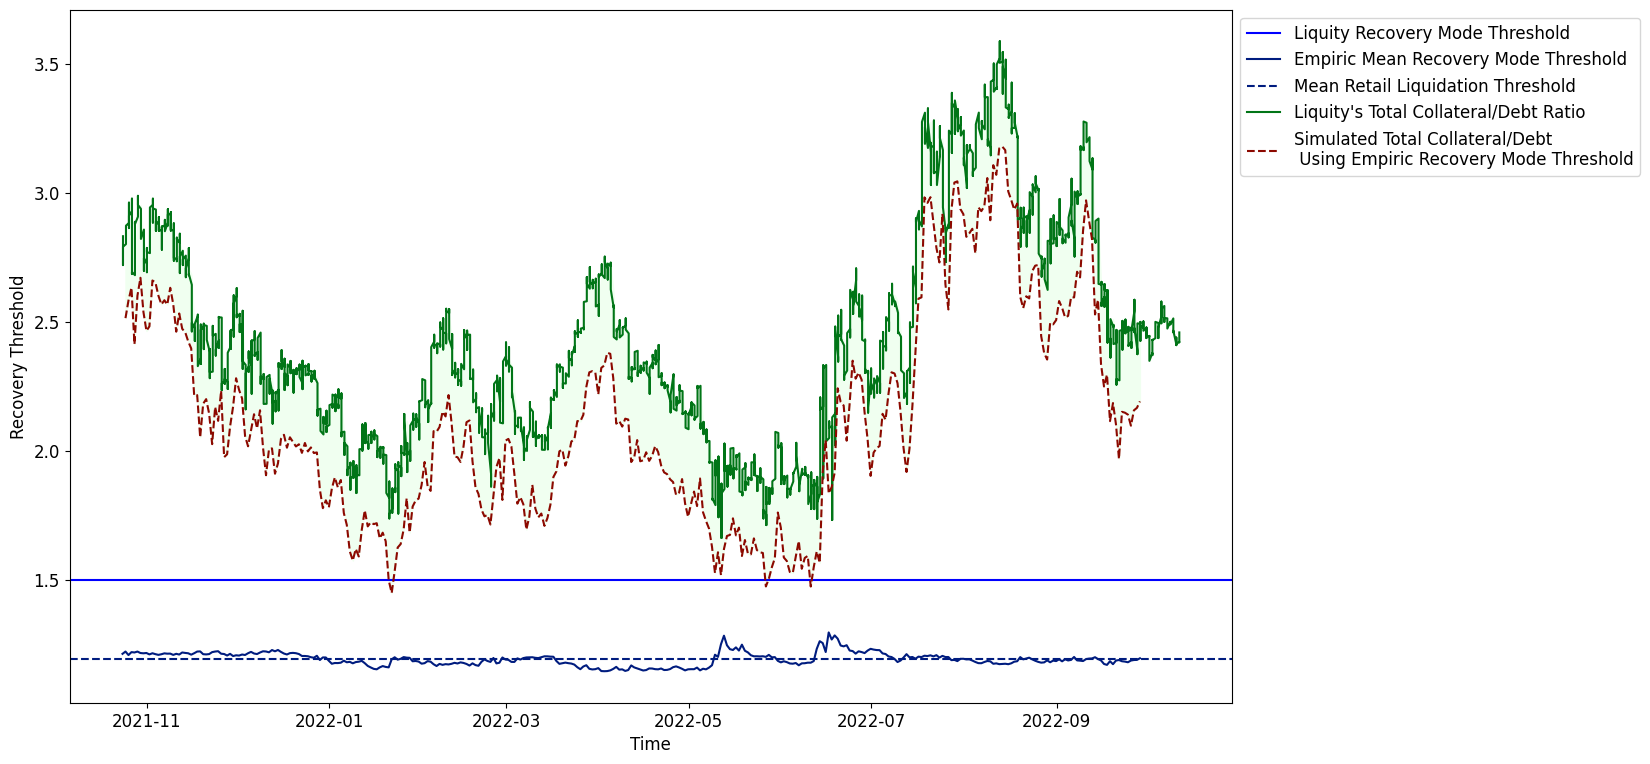

In [22]:
plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams["font.size"] = 12
plt.rcParams["font.weight"] = "normal"
plt.style.use(plt.style.available[15])
fig = plt.figure()

dates=[datetime.fromtimestamp(ts) for ts in market_df.index]
l_dates=[datetime.fromtimestamp(ts) for ts in l_df.index]

xfmt = md.DateFormatter('%Y-%m') 
ax=plt.gca()
ax.xaxis.set_major_formatter(xfmt)


plt.axhline( 1.5, label = "Liquity Recovery Mode Threshold", color = "blue")
plt.plot(dates, rmodeThreshold, label = "Empiric Mean Recovery Mode Threshold")
plt.axhline(np.mean(rmodeThreshold), linestyle="dashed", label = 'Mean Retail Liquidation Threshold')
plt.plot(l_dates, l_df["TCR"], label = "Liquity's Total Collateral/Debt Ratio")
improved_CE = ml_df["TCR"] - (1.5 - rmodeThreshold)
plt.plot(dates, improved_CE, linestyle= "dashed", label = "Simulated Total Collateral/Debt \n Using Empiric Recovery Mode Threshold")
plt.fill_between(dates, ml_df["TCR"], improved_CE, color = "honeydew")

plt.ylabel('Recovery Threshold')
plt.xlabel('Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.show

However, the real efficiency doesn't come from optimizing liquidation thresholds for each loan. The chart above shows the total collateral ratio of Liquity. The protocol tends to adjust their collateral anytime they approach 150\% CDR to avoid triggering Recovery Mode. We show that even in times of market turmoil, 1.5 is too excessive a threshold. Empiric uses market volatility to set the total CDR in such a way that there 0.0001% chance of the protocol becoming insolvent. This threshold is on average 30\% more capital efficient that the current solution than Liquity's current fixed threshold. The area between the dashed red and green line are the total capital efficiency introduced to the system by a dynamic CDR.